# Named Entity Recognition Machine Learning Model
#### This model will be used to extract human names from a given sentence
Dataset used: https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus
Entities in dataset labelled using the BIO scheme, each label prefixed with either B or I. B denotes beginning and I denotes inside. The words which are not of interest have the O tag.

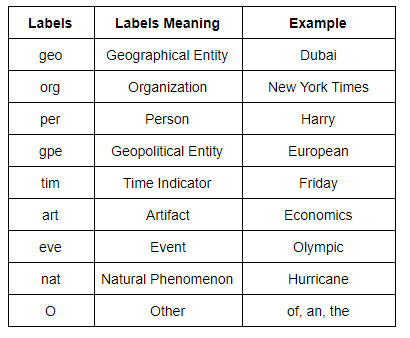

## Preprocessing

Read the dataset and make some observations about it

In [5]:
import pandas as pd
df = pd.read_csv('ner_dataset.csv', encoding="ISO-8859-1")
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048565,1048575,1048575
unique,47959,35177,42,17
top,Sentence: 1,the,NN,O
freq,1,52573,145807,887908


Observations: 
- 47959 unique sentences
- 35177 unique words
- 17 unique tags

What are the tags?

In [6]:
df.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

Check if there are any null values and remove them if there are

In [7]:
df.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

Let's fill in the missing values using pandas fill technique

In [8]:
df = df.fillna(method="ffill")
df.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

What does the data frame look like now?

In [9]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Let's clean this up a bit. The Sentence # should just be an integer, we don't need the "Sentence :" part.

In [10]:
df['Sentence #'] = df['Sentence #'].str.replace('Sentence: ', '').astype(int)

Extract the individual sentences without their tags

In [11]:
sentences_df = df.groupby('Sentence #')['Word'].apply(' '.join).reset_index()
print(sentences_df.head(2).to_string())

   Sentence #                                                                                                                                                                  Word
0           1                     Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
1           2  Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "


Lets prepare the data to go into the model. It will be a list of tuples with each tuple of the form ('Word', 'POS', 'Tag')

In [12]:
def prepare_data(sentence):
    return [(word, pos, tag) for word, pos, tag in zip(sentence['Word'], sentence['POS'], sentence['Tag'])]
grouped = df.groupby('Sentence #').apply(prepare_data)
sentences = [sentence for sentence in grouped]

`sentences` is what we will pass into the model. Preprocessing is complete!

## Training
Now that we have preprocessed the data to pass into the model, we can train the model on this data. 
The first step is to split the data into two sets, a training set which will be used to train the model and a validation set which will be used to evaluate the performance of the model.

First we will write a function which converts the word, POS and tag information into features for the model by considering the previous and current word.

In [13]:
def extract_features(sentence, index):
    word, pos, _ = sentence[index]
    
    # Each word will have a set of features that will be used to train the model
    features = {
        'word': word,               # The word itself
        'pos': pos,                 # Part-of-speech tag
        'word.lower()': word.lower(),   # Lowercased word
        'pos[:2]': pos[:2],         # First two characters of the POS tag
    }

    # current word is not the first word in the sentence
    if index > 0:
        prev_word, prev_pos, _ = sentence[index - 1]
        # add features for the previous word to the features of the current word
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:pos': prev_pos,
        })

    # current word is first word in the sentence    
    else:
        features['BOS'] = True # beginning of sentence
    
    # current word is not the last word in the sentence
    if index < len(sentence) - 1:
        next_word, next_pos, _ = sentence[index + 1]
        # add features for the next word to the features of the current word
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:pos': next_pos,
        })
    # current word is the last word in the sentence
    else:
        features['EOS'] = True # end of sentence
    
    return features

def sentence_to_features(sentence):
    return [extract_features(sentence, i) for i in range(len(sentence))]

# get the features for every word of every sentence -> this is the X input to our model
X = [sentence_to_features(sentence) for sentence in sentences]
# get the tag for every word of every sentence -> this is the Y input to our model
y = [[tag for _, _, tag in sentence] for sentence in sentences]

The above code gets the (X, y) input that we will use to train our model. 
The X data represents the input features that provide context to our model. In this case, our X data is made up of words and their POS, which will be given as context to the model to make predictions. The y are labels (in our case tags) that indicate the entity type of the word. The model learns to predict the labels (y) based on the provided features (X).

Now let's split the data into training and validation sets. 
I will use 80% of the data to train the model and 20% of the data to evaluate it. This can be changed for best results.

In [14]:
train_ratio = 0.8 # 80% of data used to train
train_index = int(train_ratio * len(X))

X_train, X_val = X[:train_index], X[train_index:] 
y_train, y_val = y[:train_index], y[train_index:]

### Create and Train Model

In [15]:
import sklearn_crfsuite

model = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1 = 0.1,
    c2 = 0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Fit the training data on the model
model.fit(X_train, y_train)

# Predict the valuation set using the model
y_val_predicted = model.predict(X_val)

In [16]:
print(y_val[0])
print(y_val_predicted[0])

['O', 'O', 'O', 'O', 'B-gpe', 'B-per', 'I-per', 'I-per', 'O', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-gpe', 'B-per', 'I-per', 'I-per', 'O', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Evaluate the Models Performance

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

mlb = MultiLabelBinarizer()
y_val_bin = mlb.fit_transform(y_val)
y_val_pred_bin = mlb.fit_transform(y_val_predicted)

# Convert binary labels back to original labels
label_names = mlb.classes_
y_val_labels = mlb.inverse_transform(y_val_bin)
y_val_pred_labels = mlb.inverse_transform(y_val_pred_bin)

# Calculate classification report using label names
classification_report = metrics.classification_report(y_val_bin, y_val_pred_bin, target_names=model.classes_)
print(classification_report)

              precision    recall  f1-score   support

           O       0.23      0.09      0.13        74
       B-geo       0.70      0.49      0.58        43
       B-gpe       0.90      0.95      0.93      4869
       B-per       0.98      0.96      0.97      2605
       I-geo       0.73      0.56      0.64        39
       B-org       0.85      0.80      0.82      3204
       I-org       0.90      0.89      0.89      2671
       B-tim       0.98      0.94      0.96      3459
       B-art       0.07      0.03      0.05        30
       I-art       0.43      0.23      0.30        26
       I-per       0.84      0.85      0.84      1173
       I-gpe       0.96      0.65      0.77        34
       I-tim       0.71      0.56      0.63         9
       B-nat       0.86      0.83      0.84      1739
       B-eve       0.89      0.95      0.92      2110
       I-eve       0.90      0.81      0.85       844
       I-nat       1.00      1.00      1.00      9590

   micro avg       0.93   

Overall pretty solid results. Some classes are more accurate (B-gpe, B-per, B-org, etc) than others (B-art, I-art). The model can be tweaked if using the algorithm for a specific class.

## Algorithm Example Usage
Lets use the model to try to extract human names from a given sentence. 
The sentence will be:
"Areez Visram studied at McMaster University"

In [26]:
import nltk
sentence = "Areez Visram studied at McMaster University"
tokens = sentence.split()
pos_tags = nltk.pos_tag(tokens)

input_sequence = [(word, pos, "O") for word, (word, pos) in zip(tokens, pos_tags)]
features = [sentence_to_features(input_sequence)]
labels = model.predict(features)

human_names = []
current_name = []
for label, (word, pos, _) in zip(labels[0], input_sequence):
    if label == "B-per":
        current_name = [word]
    elif label == "I-per" and current_name:
        current_name.append(word)
    elif current_name:
        human_names.append(" ".join(current_name))
        current_name = []

# Print the extracted human names
print("Extracted Human Names:", human_names)

Extracted Human Names: ['Areez Visram']


The model accurately extracts my name from the sentence!